# 19. 더 많은 계층

In [2]:
library(bayesrules)
library(tidyverse)
library(bayesplot)
library(rstanarm)
library(janitor)
library(tidybayes)
library(broom.mixed)

<br>

## 19.01. 그룹별 수준을 고려한 설명변수

In [3]:
data(airbnb)

In [4]:
airbnb %>% 
  summarize(nlevels(neighborhood), min(price), max(price))

nlevels(neighborhood),min(price),max(price)
<int>,<int>,<int>
43,10,1000


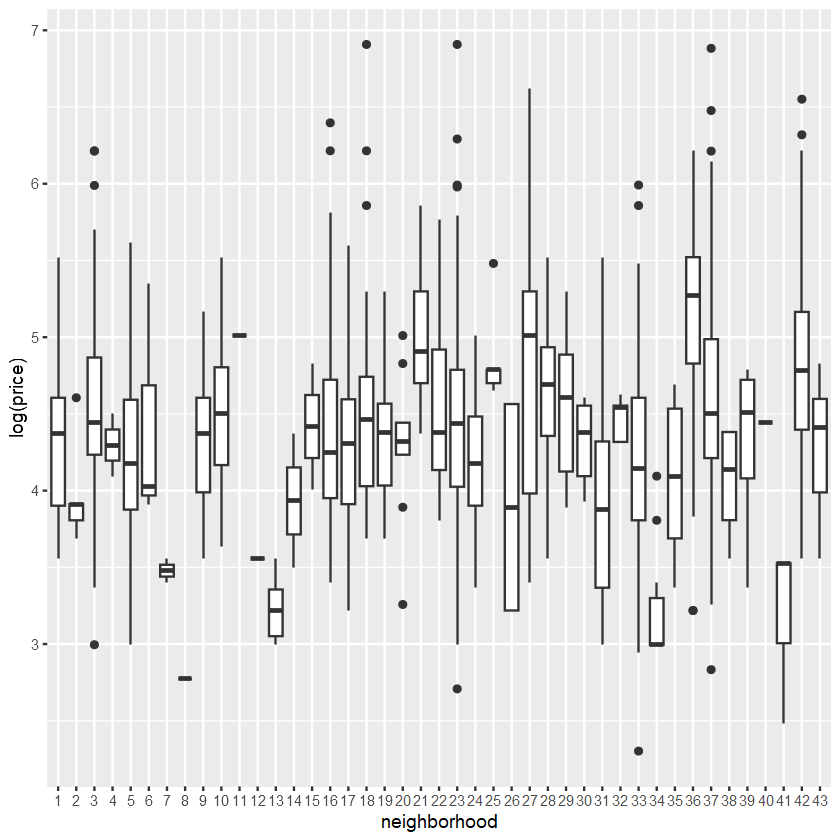

In [6]:
ggplot(airbnb, aes(y = log(price), x = neighborhood)) + 
  geom_boxplot() + 
  scale_x_discrete(labels = c(1:44))

<br>

### 한 개의 계층을 가진 모형구축
#### `neighborhood`그룹별 `room_type`그룹에 대한 계층적 모형

In [12]:
airbnb %>% select(price, bedrooms, rating, room_type, neighborhood) %>% head

,price,bedrooms,rating,room_type,neighborhood
,<int>,<int>,<dbl>,<fct>,<fct>
1,85,1,5.0,Private room,Albany Park
2,35,1,5.0,Private room,Albany Park
3,175,2,4.5,Entire home/apt,Albany Park
4,75,1,5.0,Private room,Albany Park
5,160,2,5.0,Entire home/apt,Albany Park
6,60,1,5.0,Private room,Albany Park


In [ ]:
airbnb_model_1 <- stan_glmer(
  log(price) ~ bedrooms + rating + room_type + (1 | neighborhood), 
  data = airbnb, family = gaussian,
  prior_intercept = normal(4.6, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

In [8]:
prior_summary(airbnb_model_1)

Priors for model 'airbnb_model_1' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 4.6, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 4.6, scale = 1.6)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0,...], scale = [2.5,2.5,2.5,...])
  Adjusted prior:
    ~ normal(location = [0,0,0,...], scale = [2.01,4.66,3.19,...])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 1.6)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{rll}
\log(Y_{ij}) | \beta_{0j}, \beta_1, \ldots, \beta_4, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) & \text{(within neighborhood $j$)} \\
\text{where } \mu_{ij} & = \beta_{0j} + \beta_1 X_{ij1} + \cdots + \beta_4 X_{ij4} & \\
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(between neighborhoods)}\\
\beta_{0c} & \sim N(4.6, 1.6^2) & \text{(global priors)} \\
\beta_1 & \sim N(0, 2.01^2) & \\
\beta_2 & \sim N(0, 4.66^2) & \\
\beta_3 & \sim N(0, 3.19^2) & \\
\beta_4 & \sim N(0, 8.98^2) & \\
\sigma_y & \sim \text{Exp}(1.6)    & \\
\sigma_0 & \sim \text{Exp}(1)    & \\
\end{array}
\end{equation}$$

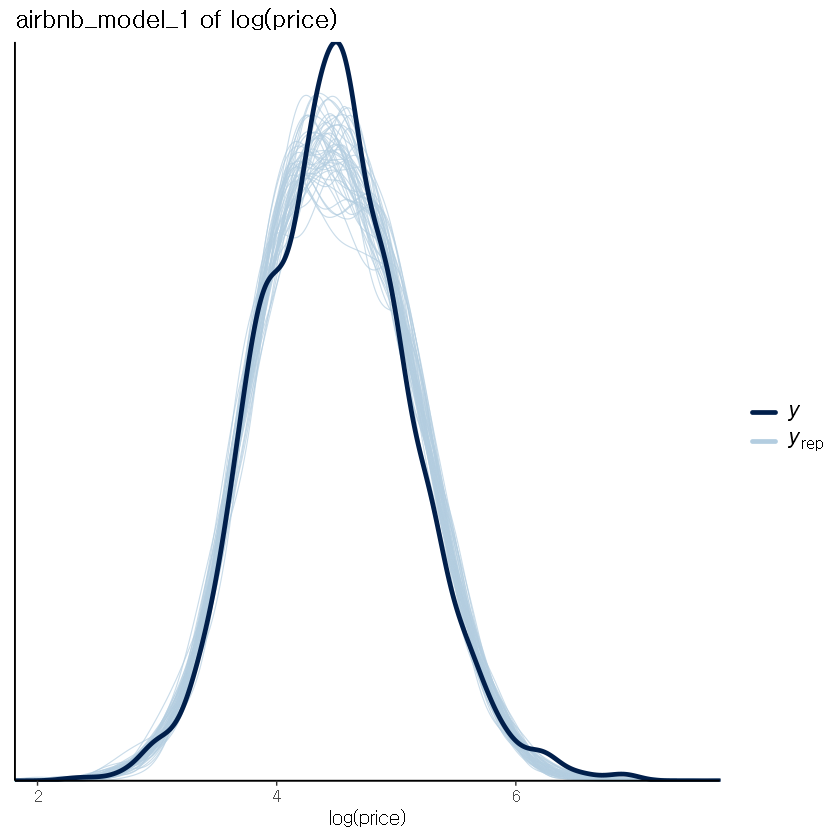

In [9]:
pp_check(airbnb_model_1) + 
  labs(title = "airbnb_model_1 of log(price)") + 
  xlab("log(price)")

In [19]:
model_1_mean <- tidy(airbnb_model_1, effects = "fixed")
model_1_mean

term,estimate,std.error
<chr>,<dbl>,<dbl>
(Intercept),3.2044585,0.14491642
bedrooms,0.2651530,0.01360665
rating,0.2197907,0.02811921
room_typePrivate room,-0.5378435,0.02258485
room_typeShared room,-1.0583872,0.05925837


<br>

## 그룹별 수준에 대한 설명변수 추가
#### `walk_score` 변수는 각 그룹별로 고유한 값을 가지며
#### 그룹내 모든 관측값에 대해서 동일한 값을 가짐

In [25]:
airbnb %>% group_by(neighborhood) %>% 
    summarise(mean(walk_score), min(walk_score), max(walk_score), median(walk_score)) %>% head(3)

neighborhood,mean(walk_score),min(walk_score),max(walk_score),median(walk_score)
<fct>,<dbl>,<int>,<int>,<dbl>
Albany Park,87,87,87,87
Archer Heights,74,74,74,74
Avondale,84,84,84,84


<br>

#### 이러한 그룹별 수준을 나타내는 변수 $U_j$를 추가하여
#### 그룹별 모형의 절편에 대하여 새로운 모형을 가정

$$\begin{equation}
\begin{array}{rll}
\log(Y_{ij}) | \beta_{0j}, \beta_1, \ldots, \beta_4, \sigma_y & \sim N(\mu_j, \sigma_y^2)  & \text{with } \mu_j = \beta_{0j} + \beta_1 X_{ij1} + \cdots + \beta_4 X_{ij4} \\
\beta_{0j} | \gamma_0, \gamma_1, \sigma_0  & \stackrel{ind}{\sim} N(\mu_{0j}, \sigma_0^2) & \text{with } \mu_{0j} = \gamma_0 + \gamma_1 U_j \\
\beta_1,\ldots,\beta_4,\gamma_0,\gamma_1,\sigma_0, \sigma_y  & \sim \text{ some priors}   &\\
\end{array}
\end{equation}$$

<hr>

$$\beta_{0j} + \beta_1 X_{ij1} + \beta_2 X_{ij2} + \beta_3 X_{ij3} + \beta_4 X_{ij4}$$

$$\downarrow$$

$$(\gamma_0 + \gamma_1 U_j) + \beta_1 X_{ij1} + \beta_2 X_{ij2} + \beta_3 X_{ij3} + \beta_4 X_{ij4}  .$$

In [ ]:
airbnb_model_2 <- stan_glmer(
  log(price) ~ walk_score + bedrooms + rating + room_type +
    (1 | neighborhood), 
  data = airbnb, family = gaussian,
  prior_intercept = normal(4.6, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

In [27]:
prior_summary(airbnb_model_2)

Priors for model 'airbnb_model_2' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 4.6, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 4.6, scale = 1.6)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0,...], scale = [2.5,2.5,2.5,...])
  Adjusted prior:
    ~ normal(location = [0,0,0,...], scale = [0.24,2.01,4.66,...])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 1.6)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

<br>

In [28]:
model_1_mean <- tidy(airbnb_model_1, effects = "fixed")
model_2_mean <- tidy(airbnb_model_2, effects = "fixed")

In [29]:
combined_summaries <- model_1_mean %>% 
  right_join(., model_2_mean, by = "term",
             suffix = c("_model_1", "_model_2")) %>% 
  select(-starts_with("std.error"))

combined_summaries

term,estimate_model_1,estimate_model_2
<chr>,<dbl>,<dbl>
(Intercept),3.2044585,1.92120292
bedrooms,0.2651530,0.26545085
rating,0.2197907,0.22063114
room_typePrivate room,-0.5378435,-0.53708385
room_typeShared room,-1.0583872,-1.05984911
walk_score,NA,0.01651562


$$\begin{array}{lr}
\text{model 1:} & 3.20 + 0.265 X_{ij1} + 0.22 X_{ij2} - 0.538 X_{ij3} - 1.06 X_{ij4} \\
\text{model 2:} & (1.92 + 0.0166 U_j) + 0.265 X_{ij1} + 0.221 X_{ij2} - 0.537 X_{ij3} - 1.06 X_{ij4}. \\
\end{array}$$

<br>

- $\sigma_y$ : `sd_Observation.Residual`
- $\sigma_0$ : `sd_(Intercept).neighborhood`

In [30]:
model_1_var <- tidy(airbnb_model_1, effects = "ran_pars")
model_2_var <- tidy(airbnb_model_2, effects = "ran_pars")

In [31]:
model_1_var %>% 
  right_join(., model_2_var, by = "term",
             suffix = c("_model_1", "_model_2")) %>% 
  select(-starts_with("group"))

term,estimate_model_1,estimate_model_2
<chr>,<dbl>,<dbl>
sd_(Intercept).neighborhood,0.2773661,0.2021507
sd_Observation.Residual,0.3652896,0.3656361


<br>

### 사후분포 분석

- 각 그룹별 수준에 대한 변수

In [41]:
nbhd_features <- airbnb %>% 
  group_by(neighborhood, walk_score) %>% 
  summarize(mean_log_price = mean(log(price)), n_listings = n()) %>% 
  ungroup()

nbhd_features %>% 
  filter(neighborhood %in% c("Edgewater", "Pullman"))

`summarise()` has grouped output by 'neighborhood'. You can override using the `.groups` argument.


neighborhood,walk_score,mean_log_price,n_listings
<fct>,<int>,<dbl>,<int>
Edgewater,89,4.468436,35
Pullman,49,4.471424,5


- 각 모형별 절편 추정량

In [35]:
combined_summaries %>% 
  filter(term %in% c("(Intercept)", "walk_score"))

term,estimate_model_1,estimate_model_2
<chr>,<dbl>,<dbl>
(Intercept),3.204459,1.92120292
walk_score,NA,0.01651562


<br>

- 각 그룹과 모형별 $b_0$ 추정량

In [42]:
model_1_nbhd <- tidy(airbnb_model_1, effects = "ran_vals")
model_2_nbhd <- tidy(airbnb_model_2, effects = "ran_vals")

In [34]:
model_1_nbhd %>% 
  right_join(., model_2_nbhd, by = "level",
             suffix = c("_model_1", "_model_2")) %>% 
  select(-starts_with(c("group", "term", "std.error"))) %>% 
  filter(level %in% c("Edgewater", "Pullman"))

level,estimate_model_1,estimate_model_2
<chr>,<dbl>,<dbl>
Edgewater,0.06972634,-0.1076953
Pullman,0.06202719,0.3201116


<br>

#### 따라서
$$\begin{equation}
\begin{array}{lrr}
\text{model 1:} & \beta_{0j} = & \beta_0 + b_{0j} \\
\text{model 2:} & \beta_{0j} = & \gamma_0 + \gamma_1 U_j + b_{0j}. \\
\end{array}
\end{equation}$$**에 의하여**

<table>
<thead>
<tr class="header">
<th>neighborhood</th>
<th>model 1 intercept</th>
<th>model 2 intercept</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>Edgewater</td>
<td>3.20 + 0.0697 = 3.28</td>
<td>1.92 + 0.0165<code>*</code>89 - 0.108 = 3.29</td>
</tr>
<tr class="even">
<td>Pullman</td>
<td>3.20 + 0.062 = 3.27</td>
<td>1.92 + 0.0165<code>*</code>49 + 0.32 = 3.05</td>
</tr>
</tbody>
</table>

<br>

## 19.02. 더 많은 계층을 가진 모형

In [46]:
data(climbers_sub)

climbers <- climbers_sub %>% 
  select(peak_name, expedition_id, member_id, success,
         year, season, age, expedition_role, oxygen_used)

In [52]:
climbers %>% head

peak_name,expedition_id,member_id,success,year,season,age,expedition_role,oxygen_used
<fct>,<chr>,<fct>,<lgl>,<dbl>,<fct>,<dbl>,<fct>,<lgl>
Ama Dablam,AMAD81101,AMAD81101-03,TRUE,1981,Spring,28,Climber,FALSE
Ama Dablam,AMAD81101,AMAD81101-04,TRUE,1981,Spring,27,Exp Doctor,FALSE
Ama Dablam,AMAD81101,AMAD81101-02,TRUE,1981,Spring,35,Deputy Leader,FALSE
Ama Dablam,AMAD81101,AMAD81101-05,TRUE,1981,Spring,37,Climber,FALSE
Ama Dablam,AMAD81101,AMAD81101-06,TRUE,1981,Spring,43,Climber,FALSE
Ama Dablam,AMAD81101,AMAD81101-07,FALSE,1981,Spring,38,Climber,FALSE


In [53]:
expeditions <- climbers %>% 
  group_by(peak_name, expedition_id) %>% 
  summarize(n_climbers = n())

head(expeditions, 2)

`summarise()` has grouped output by 'peak_name'. You can override using the `.groups` argument.


peak_name,expedition_id,n_climbers
<fct>,<chr>,<int>
Ama Dablam,AMAD03107,5
Ama Dablam,AMAD03327,6


In [54]:
peaks <- expeditions %>% 
  group_by(peak_name) %>% 
  summarize(n_expeditions = n(), n_climbers = sum(n_climbers))

head(peaks, 2)

peak_name,n_expeditions,n_climbers
<fct>,<int>,<int>
Ama Dablam,27,210
Annapurna I,6,62


<br>

#### 위 데이터는 `peak_name` $\rightarrow$ `expedition_id`의 2중 계층 구조로 구성

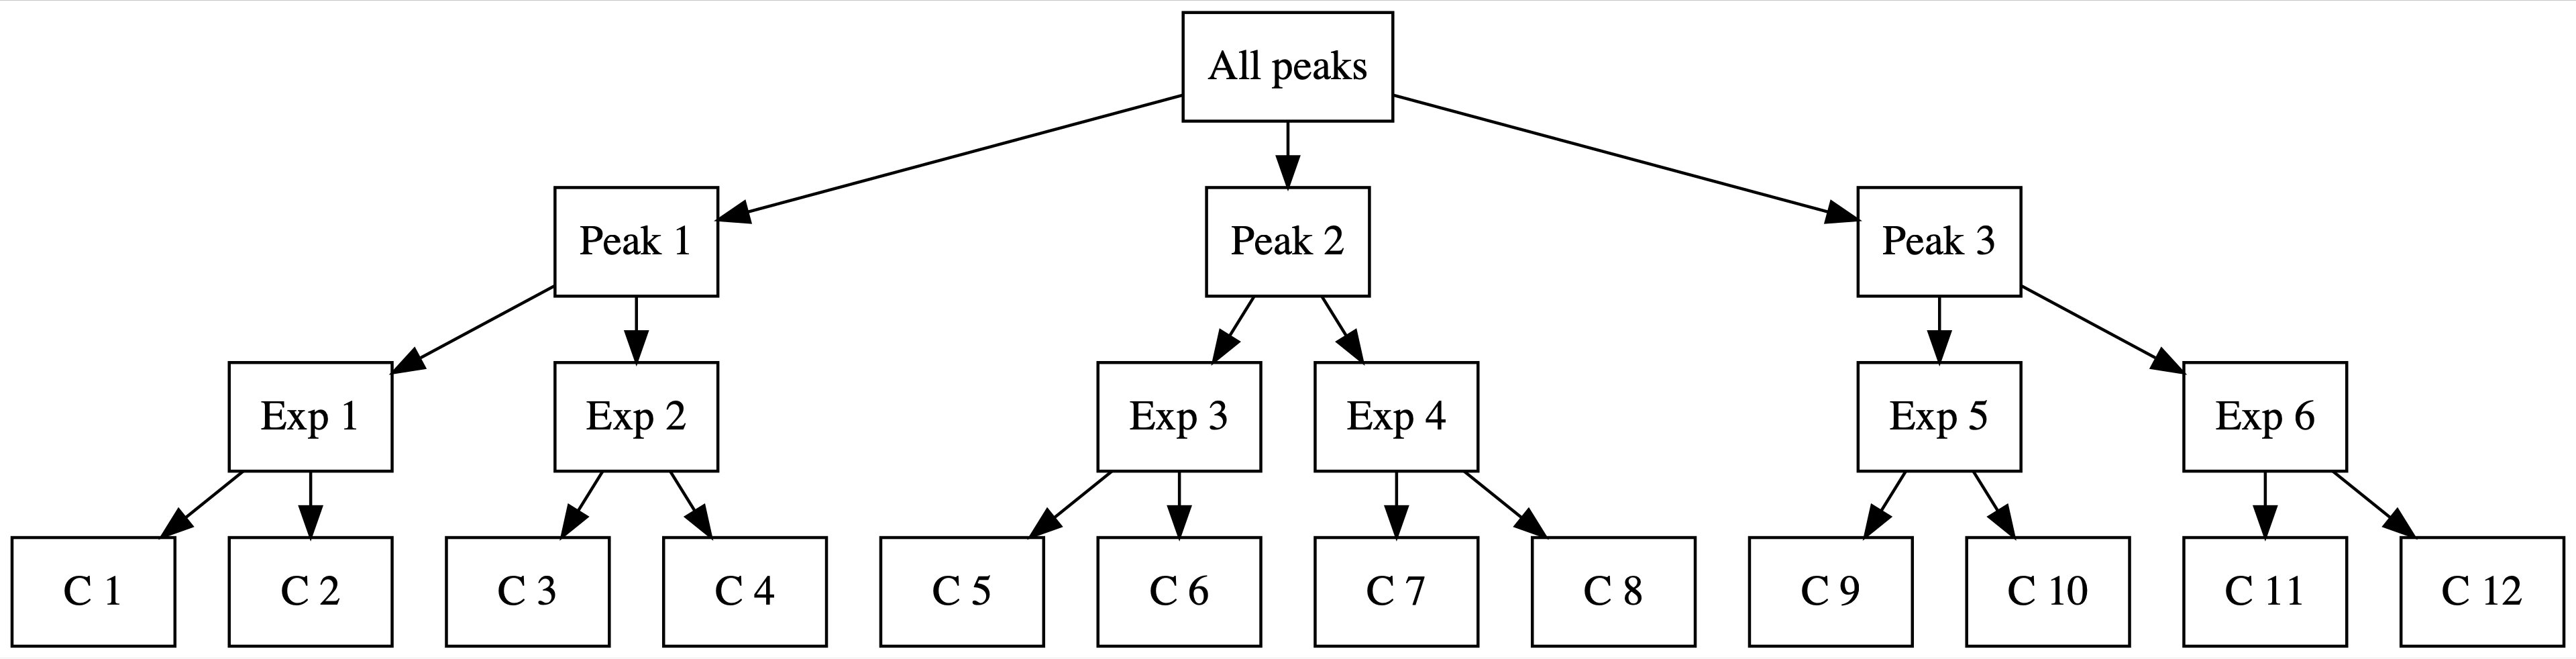

<br>

### 모형구축
#### `expedition_id`만 고려

In [ ]:
climb_model_1 <- stan_glmer(
  success ~ age + oxygen_used + (1 | expedition_id), 
  data = climbers, family = binomial,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

#### `peak_name`, `expedition_id` 모두 고려

In [ ]:
climb_model_2 <- stan_glmer(
  success ~ age + oxygen_used + (1 | expedition_id) + (1 | peak_name), 
  data = climbers, family = binomial,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

<br>

### 사후분포 해석

$$\begin{equation}
\log\left(\frac{\pi_{ijk}}{1 - \pi_{ijk}}\right) = (\beta_0 + b_{0j} + p_{0k}) + \beta_1 X_{ijk1} + \beta_2 X_{ijk2}  .
\end{equation}$$

<br>

#### 각 그룹별 전역 회귀계수

In [57]:
climb_model_2_mean <- tidy(climb_model_2, effects = "fixed")

In [62]:
climb_model_2_mean %>% 
  select(term, estimate)

term,estimate
<chr>,<dbl>
(Intercept),-1.54245568
age,-0.04723285
oxygen_usedTRUE,6.18401651


<br>

#### 각 그룹별 $b_0$, $p_0$

In [64]:
group_levels_2 <- tidy(climb_model_2, effects = "ran_vals") %>% 
  select(level, group, estimate)

In [65]:
group_levels_2 %>% 
  filter(group == "peak_name") %>% 
  head(2)

level,group,estimate
<chr>,<chr>,<dbl>
Ama_Dablam,peak_name,2.902001
Annapurna_I,peak_name,-2.016332


In [66]:
group_levels_2 %>% 
  filter(group == "expedition_id") %>% 
  head(2)

level,group,estimate
<chr>,<chr>,<dbl>
AMAD03107,expedition_id,-0.00179597
AMAD03327,expedition_id,3.35644621


<br>

#### 따라서, 3개의 그룹 A, B, C에 대한 그룹별 회귀모형은

- A : `expedition_id` = `AMAD03327` / `peak_name` = `Ama_Dablam` 

- B : `expedition_id` = `AMAD03107` / `peak_name` = `Ama_Dablam` 

- C : `expedition_id` = `AMAD03107` / `peak_name` = `Annapurna_I`


$$\begin{array}{llcl}
\text{Group a: } &  \log\left(\frac{\pi}{1 - \pi}\right) = & (-1.55 + 3.36 + 2.9) & - 0.0472 X_1 + 6.18 X_2 \\
\text{Group b: } &  \log\left(\frac{\pi}{1 - \pi}\right) = & (-1.55 + 0 + 2.9) & - 0.0472 X_1 + 6.18 X_2 \\
\text{Group c: } &  \log\left(\frac{\pi}{1 - \pi}\right) = & (-1.55 + 0 + 0) & - 0.0472 X_1 + 6.18 X_2 \\
\end{array}$$